### Data Science Game 2017

Data fields

    media_id - identifiant of the song listened by the user
    album_id - identifiant of the album of the song
    media_duration - duration of the song
    user_gender -  gender of the user
    user_id -  anonymized id of the user
    context_type - type of content where the song was listened: playlist, album ...
    release_date - release date of the song with the format YYYYMMDD
    ts_listen - timestamp of the listening in UNIX time
    platform_name - type of os
    platform_family - type of device
    user_age - age of the user
    listen_type - if the songs was listened in a flow or not
    artist_id - identifiant of the artist of the song
    genre_id - identifiant of the genre of the song
    is_listened - 1 if the track was listened, 0 otherwise


In [1]:
import pandas as pd
import numpy as np

In [2]:
df_train = pd.read_csv("../data/train_data4.csv")
df_test = pd.read_csv("../data/test_data4.csv")

df_train["user_id_id"] = df_train["user_id"]
df_test["user_id_id"] = df_test["user_id"]

In [3]:
len(df_train)
test_user_ids = df_test["user_id"].unique()
df_train["ts_listen"] = pd.to_datetime(df_train["ts_listen"] )
df_test["ts_listen"] = pd.to_datetime(df_test["ts_listen"] )


In [ ]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

def delayed_data(data, delayed_columns, delays=1, start_delay=1):
    """ Retorna um Dataframe com o delay indicado aplicado na lista de colunas indicadas
    
    Params:
        data: um dataframe com os dados originais
        delayed_columns: uma lista de strings com o nome das colunas que quero aplicar o delay
        delays: um int com a quantidade de delays desejados
    Returns:
        df: um dataframe com as colunas indicadas delayadas e já com os dados deslocados retirados
    """
    new_columns_names = []
    df = pd.DataFrame()
    df = data.copy()

    ### Aplico a série de delay em todas as colunas
    for column in delayed_columns:
        for i in range(start_delay, delays + 1):   
            ### Crio uma nova coluna com o delay
            new_columns_names.append(column + "_delayed_" + str(i))
            df[column + "_delayed_" + str(i)] = df[column].shift(i)
            
    ### Excluo os dados que ficam com NaN por causa
    ### do deslocamento.
    df = df.iloc[delays:]
    return df, new_columns_names

def random_sampler(df, user_ids, multiple=1):
    """
    df: a DataFrame to sample from;
    user_ids: a list / array with user ids you want to see in your sample
    multiple: the quantity of examples each id should present in the sample,
              if there is not enough examples in the df for a certain id,
              it returns all of them.
    ---
    sample_index: an array with df indices for the sample
    """
    sample_index = []
    for user_id in user_ids:
        #l = df[df["user_id"] == user_id].index.values
        l = df[df["user_id"] == user_id].iloc[-1].index
        if multiple <= len(l):
            x = np.random.choice(l, multiple, replace=False) 
            sample_index.append(x)
        else:
            sample_index.append(l)
    return np.concatenate(sample_index, axis=0)


def time_series_split(data, proportion=0.8, val=True, verbose=1):
    """
    """
    ### Estou assumindo que o target sempre será a partir da primeira coluna
    features = data.columns.values[1:]
    target = data.columns.values[0]
    train_size = int(len(data) * proportion)
    X_train = data.iloc[0:train_size][features]
    y_train = data.iloc[0:train_size][target]
    
    #test_prop = 1.0 - proportion / 2.0
    X_test = data.iloc[train_size:][features]
    y_test = data.iloc[train_size:][target]
    
    if val:
        index = int(len(X_test)/2)
        X_val = X_test[:index]
        y_val = y_test[:index]

        X_test = X_test[index:]
        y_test = y_test[index:]

        if verbose:
            print("Tamanho do treino: {0}, teste {1} e validação {2}.".format(len(X_train), len(X_test), len(X_val)))
        return X_train, y_train, X_val, y_val, X_test, y_test
    else:
        if verbose:
            print("Tamanho do treino: {0}, teste {1}.".format(len(X_train), len(X_test)))
        return X_train, y_train, X_test, y_test

#ids_for_test = random_sampler(df_train, test_user_ids)

In [5]:
# df_train_.iloc[0]["diff_last_ts_listen"].seconds

In [6]:
df_test["user_id_id"].min()

0

### Analisando quantidade de registro por usuário

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
#plt.style.use(['dark_background'])
#plt.style.use('ggplot')
register_count = df_train["user_id"].value_counts()
register_count.describe()
# plt.show()

count    19918.000000
mean       379.496787
std        508.267045
min          1.000000
25%         66.000000
50%        197.000000
75%        495.000000
max       6317.000000
Name: user_id, dtype: float64

In [8]:
register_count[:5].index.values

array([0, 1, 2, 3, 4])

In [9]:
df_train = df_train[df_train["user_id"].isin(register_count[:].index.values)]

(array([  1.61650000e+04,   2.60900000e+03,   7.13000000e+02,
          2.60000000e+02,   9.50000000e+01,   3.80000000e+01,
          2.10000000e+01,   8.00000000e+00,   6.00000000e+00,
          3.00000000e+00]),
 array([  1.00000000e+00,   6.32600000e+02,   1.26420000e+03,
          1.89580000e+03,   2.52740000e+03,   3.15900000e+03,
          3.79060000e+03,   4.42220000e+03,   5.05380000e+03,
          5.68540000e+03,   6.31700000e+03]),
 <a list of 10 Patch objects>)

/home/ubuntu/anaconda3/envs/ml/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


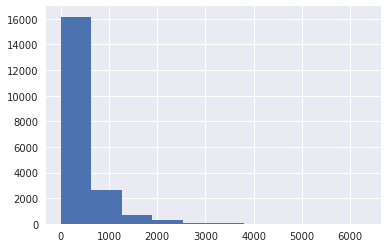

In [10]:
%matplotlib inline
plt.hist(df_train["user_id"].value_counts())

In [11]:
threshold = 30

user_for_general_model = register_count[(register_count <= threshold)].index
user_for_specific_model = register_count[(register_count > threshold)].index
print(len(user_for_general_model))
print(len(user_for_specific_model))

2630
17288


In [ ]:
print(len(df_train))
print(len(df_test))

7558817
19918


In [ ]:
### fix

for column in df_test.columns:
    try:
        df_test[column] = df_test[column].fillna(df_train[column].mean(skipna=True))
    except:
        df_test[column].fillna(0, inplace=True)

print_full(pd.isnull(df_test).sum())

In [221]:
users = df_train["user_id"].unique()[:50]
from tqdm import tqdm
all_dfs = []

df_train["is_train"] = 1
df_train["sample_id"] = 1
df_test["is_train"] = 0
df_test["is_listened"] = 0

df_train_ = pd.concat([df_train, df_test])

#print(pd.isnull(df_train_).sum())

print(pd.isnull(df_train_[df_train_["is_train"] == 0]).sum())

df_train_["is_listened"] = df_train_["is_listened"].apply(lambda x : float(x))
df_train_["listen_type"] = df_train_["listen_type"].apply(lambda x : float(x))

print(len(df_train_))

for user in tqdm(user_for_specific_model[:30]):
    df = df_train_[df_train_["user_id"] == user] #.copy(deep=True)
    print(len(df))
    df = df.sort("ts_listen")
    
    df["flow_listened"] = df["is_listened"] * df["listen_type"]
    df["flows_listened_last_10"] = df["flow_listened"].rolling(10).apply(lambda x : np.sum(x))
    df["flows_listened_mean_last_10"] = df["flow_listened"].rolling(10).apply(lambda x : np.mean(x))
    
    print(df["flow_listened"].head())
    
    print(df["flows_listened_mean_last_10"].head(15))
    
    print(df["flow_listened"].head())
    #df.drop(["flow_listened"], axis=1, inplace=True)
    print(pd.isnull(df).sum())
    
    print(pd.isnull(df_train_[df_train_["is_train"] == 0]).sum())
    
    df["diff_last_ts_listen"] = df["ts_listen"].diff()
    df.dropna(inplace=True)
    
    
    df["diff_last_ts_listen"] = df["diff_last_ts_listen"].apply(lambda x : x.seconds / 3600.0)
    
    df, cols = delayed_data(df, ["diff_last_ts_listen", 
                                 "is_listened", 
                                 "listen_type", 
                                 "flow_listened",
                                 "flows_listened_last_10", 
                                 "flows_listened_mean_last_10"], 10)
    
    
    print("null")
    print(pd.isnull(df).sum().sum())
    df.drop(["flow_listened",
            "flows_listened_last_10",
            "flows_listened_mean_last_10"], axis=1, inplace=True)
    
    print("len final: {}".format(len(df)))
    


    print("len final: {}".format(len(df)))
    
    all_dfs.append(df)
    
df_train_ = pd.concat(all_dfs)
print(len(df_train_))
df_train_.head()

Unnamed: 0                             0
Unnamed: 0.1                           0
album_id                               0
artist_albuns                         61
artist_fans                           61
artist_id                              0
artist_radio                          61
context_type                           0
diff_ts_listen_AND_release_date_D      0
diff_ts_listen_AND_release_date_M      0
diff_ts_listen_AND_release_date_Y      0
diff_user_song_age                     0
genre_id                               0
is_listened                            0
is_train                               0
listen_type                            0
media_bpm                            337
media_decade                           0
media_duration                         0
media_id                               0
media_rank                           337
platform_family                        0
platform_name                          0
release_date                           0
release_date_DAY

  0%|          | 0/30 [00:00<?, ?it/s]

7578735
6318
682493     0.0
4454931    0.0
5354506    0.0
5899441    0.0
4716560    0.0
Name: flow_listened, dtype: float64
682493     NaN
4454931    NaN
5354506    NaN
5899441    NaN
4716560    NaN
2859232    NaN
3796047    NaN
1209271    NaN
6888421    NaN
6714875    0.0
2385840    0.0
3706429    0.0
5975942    0.0
3731303    0.0
1215946    0.0
Name: flows_listened_mean_last_10, dtype: float64
682493     0.0
4454931    0.0
5354506    0.0
5899441    0.0
4716560    0.0
Name: flow_listened, dtype: float64
Unnamed: 0                           0
Unnamed: 0.1                         0
album_id                             0
artist_albuns                        0
artist_fans                          0
artist_id                            0
artist_radio                         0
context_type                         0
diff_ts_listen_AND_release_date_D    0
diff_ts_listen_AND_release_date_M    0
diff_ts_listen_AND_release_date_Y    0
diff_user_song_age                   0
genre_id              

/home/ubuntu/anaconda3/envs/ml/lib/python2.7/site-packages/ipykernel/__main__.py:24: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


0


  3%|▎         | 1/30 [00:00<00:28,  1.00it/s]

len final: 6299
len final: 6299
6241
1318256    1.0
6087833    1.0
5278940    0.0
2859629    0.0
1217977    0.0
Name: flow_listened, dtype: float64
1318256    NaN
6087833    NaN
5278940    NaN
2859629    NaN
1217977    NaN
1576095    NaN
1254500    NaN
3004196    NaN
2379816    NaN
4040466    0.2
307888     0.1
4723587    0.0
568931     0.0
1200619    0.0
5896702    0.0
Name: flows_listened_mean_last_10, dtype: float64
1318256    1.0
6087833    1.0
5278940    0.0
2859629    0.0
1217977    0.0
Name: flow_listened, dtype: float64
Unnamed: 0                           0
Unnamed: 0.1                         0
album_id                             0
artist_albuns                        0
artist_fans                          0
artist_id                            0
artist_radio                         0
context_type                         0
diff_ts_listen_AND_release_date_D    0
diff_ts_listen_AND_release_date_M    0
diff_ts_listen_AND_release_date_Y    0
diff_user_song_age                   

  7%|▋         | 2/30 [00:01<00:23,  1.20it/s]

len final: 6222
len final: 6222
6212
6574756    0.0
610698     0.0
4457051    1.0
902340     1.0
3461215    1.0
Name: flow_listened, dtype: float64
6574756    NaN
610698     NaN
4457051    NaN
902340     NaN
3461215    NaN
2282616    NaN
4900726    NaN
279007     NaN
7153334    NaN
7132702    0.7
1125532    0.8
1185540    0.9
2352238    0.8
5283506    0.8
6290784    0.8
Name: flows_listened_mean_last_10, dtype: float64
6574756    0.0
610698     0.0
4457051    1.0
902340     1.0
3461215    1.0
Name: flow_listened, dtype: float64
Unnamed: 0                           0
Unnamed: 0.1                         0
album_id                             0
artist_albuns                        0
artist_fans                          0
artist_id                            0
artist_radio                         0
context_type                         0
diff_ts_listen_AND_release_date_D    0
diff_ts_listen_AND_release_date_M    0
diff_ts_listen_AND_release_date_Y    0
diff_user_song_age                   

 10%|█         | 3/30 [00:01<00:19,  1.38it/s]

len final: 6193
len final: 6193
5582
7292844    0.0
6366787    0.0
1777243    0.0
5260811    0.0
595415     0.0
Name: flow_listened, dtype: float64
7292844    NaN
6366787    NaN
1777243    NaN
5260811    NaN
595415     NaN
3235728    NaN
4384147    NaN
2164815    NaN
1801139    NaN
6386385    0.0
6925314    0.0
3781981    0.0
4554317    0.0
5791133    0.0
4013842    0.0
Name: flows_listened_mean_last_10, dtype: float64
7292844    0.0
6366787    0.0
1777243    0.0
5260811    0.0
595415     0.0
Name: flow_listened, dtype: float64
Unnamed: 0                           0
Unnamed: 0.1                         0
album_id                             0
artist_albuns                        1
artist_fans                          1
artist_id                            0
artist_radio                         1
context_type                         0
diff_ts_listen_AND_release_date_D    0
diff_ts_listen_AND_release_date_M    0
diff_ts_listen_AND_release_date_Y    0
diff_user_song_age                   

 13%|█▎        | 4/30 [00:02<00:16,  1.57it/s]


len final: 5562
len final: 5562
5427
1759931    0.0
1759932    0.0
6721723    0.0
3166572    0.0
1759933    0.0
Name: flow_listened, dtype: float64
1759931    NaN
1759932    NaN
6721723    NaN
3166572    NaN
1759933    NaN
399408     NaN
5162706    NaN
6407659    NaN
3582135    NaN
1083803    0.0
4626848    0.0
1006795    0.0
5686696    0.0
3166571    0.0
7553254    0.0
Name: flows_listened_mean_last_10, dtype: float64
1759931    0.0
1759932    0.0
6721723    0.0
3166572    0.0
1759933    0.0
Name: flow_listened, dtype: float64
Unnamed: 0                           0
Unnamed: 0.1                         0
album_id                             0
artist_albuns                        0
artist_fans                          0
artist_id                            0
artist_radio                         0
context_type                         0
diff_ts_listen_AND_release_date_D    0
diff_ts_listen_AND_release_date_M    0
diff_ts_listen_AND_release_date_Y    0
diff_user_song_age                  

 17%|█▋        | 5/30 [00:02<00:14,  1.72it/s]

len final: 5408
len final: 5408
5401
2223114    0.0
720758     0.0
3936027    0.0
2654252    0.0
4811937    0.0
Name: flow_listened, dtype: float64
2223114    NaN
720758     NaN
3936027    NaN
2654252    NaN
4811937    NaN
3934764    NaN
1546050    NaN
714520     NaN
1817067    NaN
2708596    0.0
17443      0.0
2612185    0.0
5740068    0.0
519890     0.0
4016188    0.0
Name: flows_listened_mean_last_10, dtype: float64
2223114    0.0
720758     0.0
3936027    0.0
2654252    0.0
4811937    0.0
Name: flow_listened, dtype: float64
Unnamed: 0                           0
Unnamed: 0.1                         0
album_id                             0
artist_albuns                        0
artist_fans                          0
artist_id                            0
artist_radio                         0
context_type                         0
diff_ts_listen_AND_release_date_D    0
diff_ts_listen_AND_release_date_M    0
diff_ts_listen_AND_release_date_Y    0
diff_user_song_age                   

 20%|██        | 6/30 [00:03<00:12,  1.86it/s]

len final: 5382
len final: 5382
5399
5904784    0.0
6461883    0.0
6462565    0.0
12906      0.0
2805903    0.0
Name: flow_listened, dtype: float64
5904784    NaN
6461883    NaN
6462565    NaN
12906      NaN
2805903    NaN
2971056    NaN
5406881    NaN
1523352    NaN
3076976    NaN
5451961    0.0
6934022    0.0
5261572    0.0
1054019    0.0
1229808    0.0
1477740    0.0
Name: flows_listened_mean_last_10, dtype: float64
5904784    0.0
6461883    0.0
6462565    0.0
12906      0.0
2805903    0.0
Name: flow_listened, dtype: float64
Unnamed: 0                           0
Unnamed: 0.1                         0
album_id                             0
artist_albuns                        0
artist_fans                          0
artist_id                            0
artist_radio                         0
context_type                         0
diff_ts_listen_AND_release_date_D    0
diff_ts_listen_AND_release_date_M    0
diff_ts_listen_AND_release_date_Y    0
diff_user_song_age                   

 23%|██▎       | 7/30 [00:03<00:11,  1.96it/s]

len final: 5380
len final: 5380
5238
6574086    0.0
6133163    0.0
1758995    0.0
5369213    0.0
6268760    0.0
Name: flow_listened, dtype: float64
6574086    NaN
6133163    NaN
1758995    NaN
5369213    NaN
6268760    NaN
4162597    NaN
7431871    NaN
7180763    NaN
6981260    NaN
1162159    0.0
2770672    0.0
7226042    0.0
2730139    0.0
3739059    0.0
2133806    0.0
Name: flows_listened_mean_last_10, dtype: float64
6574086    0.0
6133163    0.0
1758995    0.0
5369213    0.0
6268760    0.0
Name: flow_listened, dtype: float64
Unnamed: 0                           0
Unnamed: 0.1                         0
album_id                             0
artist_albuns                        0
artist_fans                          0
artist_id                            0
artist_radio                         0
context_type                         0
diff_ts_listen_AND_release_date_D    0
diff_ts_listen_AND_release_date_M    0
diff_ts_listen_AND_release_date_Y    0
diff_user_song_age                   

 27%|██▋       | 8/30 [00:04<00:10,  2.06it/s]

len final: 5219
len final: 5219
5186
4878542    1.0
2703676    1.0
2781753    1.0
2169377    1.0
4197423    1.0
Name: flow_listened, dtype: float64
4878542    NaN
2703676    NaN
2781753    NaN
2169377    NaN
4197423    NaN
5830723    NaN
4376939    NaN
3944878    NaN
6546781    NaN
7511980    1.0
1732798    1.0
6361999    1.0
1439134    1.0
6780100    1.0
572890     1.0
Name: flows_listened_mean_last_10, dtype: float64
4878542    1.0
2703676    1.0
2781753    1.0
2169377    1.0
4197423    1.0
Name: flow_listened, dtype: float64
Unnamed: 0                           0
Unnamed: 0.1                         0
album_id                             0
artist_albuns                        0
artist_fans                          0
artist_id                            0
artist_radio                         0
context_type                         0
diff_ts_listen_AND_release_date_D    0
diff_ts_listen_AND_release_date_M    0
diff_ts_listen_AND_release_date_Y    0
diff_user_song_age                   

 30%|███       | 9/30 [00:04<00:09,  2.11it/s]

len final: 5167
len final: 5167
4990
1230903    0.0
2614489    0.0
4787907    0.0
6332646    0.0
7359312    0.0
Name: flow_listened, dtype: float64
1230903    NaN
2614489    NaN
4787907    NaN
6332646    NaN
7359312    NaN
1023820    NaN
6317450    NaN
3240801    NaN
2207379    NaN
7118541    0.0
5362285    0.0
1448754    0.0
6795595    0.0
6023724    0.0
2159102    0.0
Name: flows_listened_mean_last_10, dtype: float64
1230903    0.0
2614489    0.0
4787907    0.0
6332646    0.0
7359312    0.0
Name: flow_listened, dtype: float64
Unnamed: 0                           0
Unnamed: 0.1                         0
album_id                             0
artist_albuns                        0
artist_fans                          0
artist_id                            0
artist_radio                         0
context_type                         0
diff_ts_listen_AND_release_date_D    0
diff_ts_listen_AND_release_date_M    0
diff_ts_listen_AND_release_date_Y    0
diff_user_song_age                   

 33%|███▎      | 10/30 [00:04<00:09,  2.18it/s]

len final: 4971
len final: 4971
4958
5407951    1.0
3011508    0.0
3011505    0.0
3011507    0.0
3011509    0.0
Name: flow_listened, dtype: float64
5407951    NaN
3011508    NaN
3011505    NaN
3011507    NaN
3011509    NaN
4096282    NaN
2790375    NaN
3481474    NaN
475001     NaN
3807256    0.1
1201262    0.0
5455157    0.0
3011506    0.0
5287069    0.0
5533308    0.0
Name: flows_listened_mean_last_10, dtype: float64
5407951    1.0
3011508    0.0
3011505    0.0
3011507    0.0
3011509    0.0
Name: flow_listened, dtype: float64
Unnamed: 0                           0
Unnamed: 0.1                         0
album_id                             0
artist_albuns                        0
artist_fans                          0
artist_id                            0
artist_radio                         0
context_type                         0
diff_ts_listen_AND_release_date_D    0
diff_ts_listen_AND_release_date_M    0
diff_ts_listen_AND_release_date_Y    0
diff_user_song_age                   

 37%|███▋      | 11/30 [00:05<00:08,  2.21it/s]


len final: 4939
len final: 4939
4715
6842117    0.0
5050781    0.0
6723320    0.0
6002677    0.0
5050786    0.0
Name: flow_listened, dtype: float64
6842117    NaN
5050781    NaN
6723320    NaN
6002677    NaN
5050786    NaN
5050784    NaN
2215269    NaN
1691651    NaN
5050783    NaN
6533915    0.0
5050779    0.0
1691650    0.0
2215270    0.0
6533914    0.0
5050787    0.0
Name: flows_listened_mean_last_10, dtype: float64
6842117    0.0
5050781    0.0
6723320    0.0
6002677    0.0
5050786    0.0
Name: flow_listened, dtype: float64
Unnamed: 0                           0
Unnamed: 0.1                         0
album_id                             0
artist_albuns                        0
artist_fans                          0
artist_id                            0
artist_radio                         0
context_type                         0
diff_ts_listen_AND_release_date_D    0
diff_ts_listen_AND_release_date_M    0
diff_ts_listen_AND_release_date_Y    0
diff_user_song_age                  

 40%|████      | 12/30 [00:05<00:07,  2.26it/s]

len final: 4696
len final: 4696
4626
6636057    0.0
6308485    0.0
6949618    0.0
3202315    0.0
4385303    0.0
Name: flow_listened, dtype: float64
6636057    NaN
6308485    NaN
6949618    NaN
3202315    NaN
4385303    NaN
3907043    NaN
5387615    NaN
5387617    NaN
5387616    NaN
3347800    0.0
5054204    0.0
2496077    0.0
1499485    0.0
4951173    0.0
6350259    0.0
Name: flows_listened_mean_last_10, dtype: float64
6636057    0.0
6308485    0.0
6949618    0.0
3202315    0.0
4385303    0.0
Name: flow_listened, dtype: float64
Unnamed: 0                           0
Unnamed: 0.1                         0
album_id                             0
artist_albuns                        0
artist_fans                          0
artist_id                            0
artist_radio                         0
context_type                         0
diff_ts_listen_AND_release_date_D    0
diff_ts_listen_AND_release_date_M    0
diff_ts_listen_AND_release_date_Y    0
diff_user_song_age                   

 43%|████▎     | 13/30 [00:06<00:07,  2.25it/s]

len final: 4607
len final: 4607
4564
2524724    0.0
2524713    0.0
2524705    0.0
2524716    0.0
2524718    0.0
Name: flow_listened, dtype: float64
2524724    NaN
2524713    NaN
2524705    NaN
2524716    NaN
2524718    NaN
2524714    NaN
2524726    NaN
2524710    NaN
2524721    NaN
2524725    0.0
2524730    0.0
2524706    0.0
2524708    0.0
2524727    0.0
2524707    0.0
Name: flows_listened_mean_last_10, dtype: float64
2524724    0.0
2524713    0.0
2524705    0.0
2524716    0.0
2524718    0.0
Name: flow_listened, dtype: float64
Unnamed: 0                           0
Unnamed: 0.1                         0
album_id                             0
artist_albuns                        0
artist_fans                          0
artist_id                            0
artist_radio                         0
context_type                         0
diff_ts_listen_AND_release_date_D    0
diff_ts_listen_AND_release_date_M    0
diff_ts_listen_AND_release_date_Y    0
diff_user_song_age                   

 47%|████▋     | 14/30 [00:06<00:07,  2.27it/s]

len final: 4545
len final: 4545
4544
4066255    1.0
5280747    0.0
3408164    0.0
6786508    0.0
607651     0.0
Name: flow_listened, dtype: float64
4066255    NaN
5280747    NaN
3408164    NaN
6786508    NaN
607651     NaN
1548271    NaN
3557872    NaN
2702250    NaN
5818900    NaN
6678506    0.1
4573669    0.0
5317063    0.0
3764551    0.0
702296     0.0
1506193    0.0
Name: flows_listened_mean_last_10, dtype: float64
4066255    1.0
5280747    0.0
3408164    0.0
6786508    0.0
607651     0.0
Name: flow_listened, dtype: float64
Unnamed: 0                           0
Unnamed: 0.1                         0
album_id                             0
artist_albuns                        0
artist_fans                          0
artist_id                            0
artist_radio                         0
context_type                         0
diff_ts_listen_AND_release_date_D    0
diff_ts_listen_AND_release_date_M    0
diff_ts_listen_AND_release_date_Y    0
diff_user_song_age                   

 50%|█████     | 15/30 [00:07<00:06,  2.26it/s]

len final: 4525
len final: 4525
4444
6946676    0.0
267461     0.0
2967541    0.0
6946675    0.0
2967540    0.0
Name: flow_listened, dtype: float64
6946676    NaN
267461     NaN
2967541    NaN
6946675    NaN
2967540    NaN
6946674    NaN
2884448    NaN
1318511    NaN
2884449    NaN
641667     0.0
4449616    0.0
4701990    0.0
1945444    0.0
7220318    0.0
6085514    0.1
Name: flows_listened_mean_last_10, dtype: float64
6946676    0.0
267461     0.0
2967541    0.0
6946675    0.0
2967540    0.0
Name: flow_listened, dtype: float64
Unnamed: 0                           0
Unnamed: 0.1                         0
album_id                             0
artist_albuns                        0
artist_fans                          0
artist_id                            0
artist_radio                         0
context_type                         0
diff_ts_listen_AND_release_date_D    0
diff_ts_listen_AND_release_date_M    0
diff_ts_listen_AND_release_date_Y    0
diff_user_song_age                   

 53%|█████▎    | 16/30 [00:07<00:06,  2.28it/s]

len final: 4425
len final: 4425
4436
3054869    0.0
3054872    0.0
6205115    0.0
5947742    0.0
203508     0.0
Name: flow_listened, dtype: float64
3054869    NaN
3054872    NaN
6205115    NaN
5947742    NaN
203508     NaN
4363620    NaN
799288     NaN
6674123    NaN
3180863    NaN
3082935    0.0
3082928    0.0
3082934    0.0
3082932    0.0
3082936    0.0
3082937    0.0
Name: flows_listened_mean_last_10, dtype: float64
3054869    0.0
3054872    0.0
6205115    0.0
5947742    0.0
203508     0.0
Name: flow_listened, dtype: float64
Unnamed: 0                           0
Unnamed: 0.1                         0
album_id                             0
artist_albuns                        0
artist_fans                          0
artist_id                            0
artist_radio                         0
context_type                         0
diff_ts_listen_AND_release_date_D    0
diff_ts_listen_AND_release_date_M    0
diff_ts_listen_AND_release_date_Y    0
diff_user_song_age                   

 57%|█████▋    | 17/30 [00:08<00:05,  2.27it/s]

len final: 4417
len final: 4417
4421
1937765    1.0
549805     1.0
7232213    1.0
4105393    1.0
4258388    1.0
Name: flow_listened, dtype: float64
1937765    NaN
549805     NaN
7232213    NaN
4105393    NaN
4258388    NaN
1023431    NaN
6145099    NaN
5220775    NaN
6740499    NaN
1973935    1.0
3620005    1.0
5242193    1.0
1136689    1.0
7134714    1.0
4898105    1.0
Name: flows_listened_mean_last_10, dtype: float64
1937765    1.0
549805     1.0
7232213    1.0
4105393    1.0
4258388    1.0
Name: flow_listened, dtype: float64
Unnamed: 0                           0
Unnamed: 0.1                         0
album_id                             0
artist_albuns                        0
artist_fans                          0
artist_id                            0
artist_radio                         0
context_type                         0
diff_ts_listen_AND_release_date_D    0
diff_ts_listen_AND_release_date_M    0
diff_ts_listen_AND_release_date_Y    0
diff_user_song_age                   

 60%|██████    | 18/30 [00:08<00:05,  2.29it/s]

len final: 4402
len final: 4402
4249
4352511    0.0
4662686    0.0
5527930    0.0
5160634    0.0
7094867    0.0
Name: flow_listened, dtype: float64
4352511    NaN
4662686    NaN
5527930    NaN
5160634    NaN
7094867    NaN
4503052    NaN
4911100    NaN
3349763    NaN
600371     NaN
1998962    0.0
4911108    0.0
627505     0.0
1271156    0.0
4907576    0.0
3521308    0.0
Name: flows_listened_mean_last_10, dtype: float64
4352511    0.0
4662686    0.0
5527930    0.0
5160634    0.0
7094867    0.0
Name: flow_listened, dtype: float64
Unnamed: 0                           0
Unnamed: 0.1                         0
album_id                             0
artist_albuns                        0
artist_fans                          0
artist_id                            0
artist_radio                         0
context_type                         0
diff_ts_listen_AND_release_date_D    0
diff_ts_listen_AND_release_date_M    0
diff_ts_listen_AND_release_date_Y    0
diff_user_song_age                   

 63%|██████▎   | 19/30 [00:08<00:04,  2.29it/s]

len final: 4230
len final: 4230
4234
43870      0.0
2754586    0.0
2979661    0.0
228018     0.0
2998829    0.0
Name: flow_listened, dtype: float64
43870      NaN
2754586    NaN
2979661    NaN
228018     NaN
2998829    NaN
7034982    NaN
784512     NaN
263170     NaN
2378493    NaN
1007161    0.0
5006936    0.0
4724994    0.0
7400718    0.0
4042848    0.0
1007162    0.0
Name: flows_listened_mean_last_10, dtype: float64
43870      0.0
2754586    0.0
2979661    0.0
228018     0.0
2998829    0.0
Name: flow_listened, dtype: float64
Unnamed: 0                           0
Unnamed: 0.1                         0
album_id                             0
artist_albuns                        0
artist_fans                          0
artist_id                            0
artist_radio                         0
context_type                         0
diff_ts_listen_AND_release_date_D    0
diff_ts_listen_AND_release_date_M    0
diff_ts_listen_AND_release_date_Y    0
diff_user_song_age                   

 67%|██████▋   | 20/30 [00:09<00:04,  2.31it/s]

len final: 4214
len final: 4214
4177
1067352    0.0
6665551    0.0
2271455    0.0
3691678    0.0
7006594    0.0
Name: flow_listened, dtype: float64
1067352    NaN
6665551    NaN
2271455    NaN
3691678    NaN
7006594    NaN
4345911    NaN
1522515    NaN
4272252    NaN
5614460    NaN
3030723    0.0
4166732    0.0
6665544    0.0
4826756    0.0
6176078    0.0
7415021    0.0
Name: flows_listened_mean_last_10, dtype: float64
1067352    0.0
6665551    0.0
2271455    0.0
3691678    0.0
7006594    0.0
Name: flow_listened, dtype: float64
Unnamed: 0                           0
Unnamed: 0.1                         0
album_id                             0
artist_albuns                        0
artist_fans                          0
artist_id                            0
artist_radio                         0
context_type                         0
diff_ts_listen_AND_release_date_D    0
diff_ts_listen_AND_release_date_M    0
diff_ts_listen_AND_release_date_Y    0
diff_user_song_age                   

 70%|███████   | 21/30 [00:09<00:03,  2.32it/s]

len final: 4158
len final: 4158
4171
7487565    0.0
2378356    0.0
5846758    0.0
2285616    0.0
6287240    0.0
Name: flow_listened, dtype: float64
7487565    NaN
2378356    NaN
5846758    NaN
2285616    NaN
6287240    NaN
3710114    NaN
3494277    NaN
1200599    NaN
1008466    NaN
355004     0.0
133152     0.0
1325963    0.0
1765332    0.0
6669178    0.0
6800084    0.0
Name: flows_listened_mean_last_10, dtype: float64
7487565    0.0
2378356    0.0
5846758    0.0
2285616    0.0
6287240    0.0
Name: flow_listened, dtype: float64
Unnamed: 0                           0
Unnamed: 0.1                         0
album_id                             0
artist_albuns                        0
artist_fans                          0
artist_id                            0
artist_radio                         0
context_type                         0
diff_ts_listen_AND_release_date_D    0
diff_ts_listen_AND_release_date_M    0
diff_ts_listen_AND_release_date_Y    0
diff_user_song_age                   

 73%|███████▎  | 22/30 [00:10<00:03,  2.37it/s]

len final: 4152
len final: 4152
4149
2553160    0.0
6020315    0.0
2095152    0.0
390372     0.0
5998209    0.0
Name: flow_listened, dtype: float64
2553160    NaN
6020315    NaN
2095152    NaN
390372     NaN
5998209    NaN
3880404    NaN
1317608    NaN
5610345    NaN
7142214    NaN
3932593    0.4
4394063    0.4
3461239    0.4
278990     0.4
5585021    0.4
2465546    0.4
Name: flows_listened_mean_last_10, dtype: float64
2553160    0.0
6020315    0.0
2095152    0.0
390372     0.0
5998209    0.0
Name: flow_listened, dtype: float64
Unnamed: 0                           0
Unnamed: 0.1                         0
album_id                             0
artist_albuns                        0
artist_fans                          0
artist_id                            0
artist_radio                         0
context_type                         0
diff_ts_listen_AND_release_date_D    0
diff_ts_listen_AND_release_date_M    0
diff_ts_listen_AND_release_date_Y    0
diff_user_song_age                   

 77%|███████▋  | 23/30 [00:10<00:02,  2.37it/s]

len final: 4130
len final: 4130
4142
2948404    1.0
3007822    0.0
62681      0.0
4604263    0.0
6824006    0.0
Name: flow_listened, dtype: float64
2948404    NaN
3007822    NaN
62681      NaN
4604263    NaN
6824006    NaN
2554804    NaN
3007821    NaN
62682      NaN
4604262    NaN
6824007    0.1
2554805    0.0
3881902    0.0
4162244    0.0
6374442    0.0
4675295    0.0
Name: flows_listened_mean_last_10, dtype: float64
2948404    1.0
3007822    0.0
62681      0.0
4604263    0.0
6824006    0.0
Name: flow_listened, dtype: float64
Unnamed: 0                           0
Unnamed: 0.1                         0
album_id                             0
artist_albuns                        0
artist_fans                          0
artist_id                            0
artist_radio                         0
context_type                         0
diff_ts_listen_AND_release_date_D    0
diff_ts_listen_AND_release_date_M    0
diff_ts_listen_AND_release_date_Y    0
diff_user_song_age                   

 80%|████████  | 24/30 [00:10<00:02,  2.39it/s]

len final: 4123
len final: 4123
4117
4033901    0.0
4559107    0.0
4677018    0.0
5732584    0.0
1358105    0.0
Name: flow_listened, dtype: float64
4033901    NaN
4559107    NaN
4677018    NaN
5732584    NaN
1358105    NaN
1358107    NaN
4547816    NaN
1170511    NaN
2204051    NaN
2930466    0.0
1811784    0.0
1814901    0.0
3481770    0.0
4162237    0.0
6394336    0.0
Name: flows_listened_mean_last_10, dtype: float64
4033901    0.0
4559107    0.0
4677018    0.0
5732584    0.0
1358105    0.0
Name: flow_listened, dtype: float64
Unnamed: 0                           0
Unnamed: 0.1                         0
album_id                             0
artist_albuns                        0
artist_fans                          0
artist_id                            0
artist_radio                         0
context_type                         0
diff_ts_listen_AND_release_date_D    0
diff_ts_listen_AND_release_date_M    0
diff_ts_listen_AND_release_date_Y    0
diff_user_song_age                   

 83%|████████▎ | 25/30 [00:11<00:02,  2.38it/s]


len final: 4098
len final: 4098
4109
2513237    0.0
75250      0.0
3236230    0.0
7470976    0.0
6371238    0.0
Name: flow_listened, dtype: float64
2513237    NaN
75250      NaN
3236230    NaN
7470976    NaN
6371238    NaN
3819324    NaN
2543231    NaN
5325654    NaN
1383230    NaN
3435913    0.0
6528485    0.0
5337801    0.0
5854970    0.0
7029589    0.0
7201387    0.0
Name: flows_listened_mean_last_10, dtype: float64
2513237    0.0
75250      0.0
3236230    0.0
7470976    0.0
6371238    0.0
Name: flow_listened, dtype: float64
Unnamed: 0                           0
Unnamed: 0.1                         0
album_id                             0
artist_albuns                        0
artist_fans                          0
artist_id                            0
artist_radio                         0
context_type                         0
diff_ts_listen_AND_release_date_D    0
diff_ts_listen_AND_release_date_M    0
diff_ts_listen_AND_release_date_Y    0
diff_user_song_age                  

 87%|████████▋ | 26/30 [00:11<00:01,  2.40it/s]


len final: 4090
len final: 4090
4060
1581404    0.0
1569057    1.0
3597602    1.0
2401661    1.0
7397704    1.0
Name: flow_listened, dtype: float64
1581404    NaN
1569057    NaN
3597602    NaN
2401661    NaN
7397704    NaN
1569042    NaN
2177028    NaN
3904164    NaN
215994     NaN
1799447    0.9
215987     1.0
3175395    1.0
3904165    1.0
6195606    1.0
1569051    1.0
Name: flows_listened_mean_last_10, dtype: float64
1581404    0.0
1569057    1.0
3597602    1.0
2401661    1.0
7397704    1.0
Name: flow_listened, dtype: float64
Unnamed: 0                           0
Unnamed: 0.1                         0
album_id                             0
artist_albuns                        0
artist_fans                          0
artist_id                            0
artist_radio                         0
context_type                         0
diff_ts_listen_AND_release_date_D    0
diff_ts_listen_AND_release_date_M    0
diff_ts_listen_AND_release_date_Y    0
diff_user_song_age                  

 90%|█████████ | 27/30 [00:12<00:01,  2.38it/s]

len final: 4041
len final: 4041
4036
6096093    0.0
2347223    1.0
1164757    1.0
4036705    1.0
1341217    1.0
Name: flow_listened, dtype: float64
6096093    NaN
2347223    NaN
1164757    NaN
4036705    NaN
1341217    NaN
1656430    NaN
1266360    NaN
2831862    NaN
727549     NaN
499738     0.9
6596010    1.0
3947529    1.0
1620539    1.0
5604490    1.0
1283981    1.0
Name: flows_listened_mean_last_10, dtype: float64
6096093    0.0
2347223    1.0
1164757    1.0
4036705    1.0
1341217    1.0
Name: flow_listened, dtype: float64
Unnamed: 0                           0
Unnamed: 0.1                         0
album_id                             0
artist_albuns                        0
artist_fans                          0
artist_id                            0
artist_radio                         0
context_type                         0
diff_ts_listen_AND_release_date_D    0
diff_ts_listen_AND_release_date_M    0
diff_ts_listen_AND_release_date_Y    0
diff_user_song_age                   

 93%|█████████▎| 28/30 [00:12<00:00,  2.40it/s]

len final: 4017
len final: 4017
3990
4395183    0.0
1069573    0.0
5245987    0.0
1106220    0.0
4368671    0.0
Name: flow_listened, dtype: float64
4395183    NaN
1069573    NaN
5245987    NaN
1106220    NaN
4368671    NaN
3852356    NaN
2422511    NaN
6458884    NaN
119550     NaN
1069572    0.0
7085618    0.0
3350371    0.0
2486949    0.0
2713613    0.0
2237213    0.0
Name: flows_listened_mean_last_10, dtype: float64
4395183    0.0
1069573    0.0
5245987    0.0
1106220    0.0
4368671    0.0
Name: flow_listened, dtype: float64
Unnamed: 0                           0
Unnamed: 0.1                         0
album_id                             0
artist_albuns                        0
artist_fans                          0
artist_id                            0
artist_radio                         0
context_type                         0
diff_ts_listen_AND_release_date_D    0
diff_ts_listen_AND_release_date_M    0
diff_ts_listen_AND_release_date_Y    0
diff_user_song_age                   

 97%|█████████▋| 29/30 [00:13<00:00,  2.39it/s]

len final: 3971
len final: 3971
3977
3986332    1.0
4341354    1.0
7364750    1.0
4074029    1.0
6133811    1.0
Name: flow_listened, dtype: float64
3986332    NaN
4341354    NaN
7364750    NaN
4074029    NaN
6133811    NaN
7164992    NaN
5044541    NaN
6997789    NaN
3963220    NaN
6089239    1.0
3750182    1.0
2534894    1.0
3904148    1.0
5294148    1.0
4858570    1.0
Name: flows_listened_mean_last_10, dtype: float64
3986332    1.0
4341354    1.0
7364750    1.0
4074029    1.0
6133811    1.0
Name: flow_listened, dtype: float64
Unnamed: 0                           0
Unnamed: 0.1                         0
album_id                             0
artist_albuns                        0
artist_fans                          0
artist_id                            0
artist_radio                         0
context_type                         0
diff_ts_listen_AND_release_date_D    0
diff_ts_listen_AND_release_date_M    0
diff_ts_listen_AND_release_date_Y    0
diff_user_song_age                   

100%|██████████| 30/30 [00:13<00:00,  2.41it/s]

len final: 3958
len final: 3958
141541


,Unnamed: 0,Unnamed: 0.1,album_id,artist_albuns,artist_fans,artist_id,artist_radio,context_type,diff_ts_listen_AND_release_date_D,diff_ts_listen_AND_release_date_M,...,flows_listened_mean_last_10_delayed_1,flows_listened_mean_last_10_delayed_2,flows_listened_mean_last_10_delayed_3,flows_listened_mean_last_10_delayed_4,flows_listened_mean_last_10_delayed_5,flows_listened_mean_last_10_delayed_6,flows_listened_mean_last_10_delayed_7,flows_listened_mean_last_10_delayed_8,flows_listened_mean_last_10_delayed_9,flows_listened_mean_last_10_delayed_10
6726715,6726715,6726732,13371165,13.0,2264919.0,647650,1.0,0,138.0,4.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3004664,3004664,3004670,14099768,14.0,4212388.0,4050205,1.0,0,40.0,1.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6726713,6726713,6726730,13371165,13.0,2264919.0,647650,1.0,0,138.0,4.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3004663,3004663,3004669,14099768,14.0,4212388.0,4050205,1.0,0,40.0,1.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
919206,919206,919206,13632822,59.0,15412.0,371843,1.0,0,102.0,3.400000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [222]:
df_train_["is_train"].head()

6726715    1
3004664    1
6726713    1
3004663    1
919206     1
Name: is_train, dtype: int64

In [223]:
df_train = df_train_[df_train_["is_train"] == 1]
df_test = df_train_[df_train_["is_train"] == 0]
    
df_test.drop(["is_listened"], axis=1, inplace=True)

print(len(df_train))
print(len(df_test))

141513
28


/home/ubuntu/anaconda3/envs/ml/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [224]:
len(user_for_specific_model[:30])

30

In [225]:

print_full(df_train.dtypes[:])

Unnamed: 0                                         int64
Unnamed: 0.1                                       int64
album_id                                           int64
artist_albuns                                    float64
artist_fans                                      float64
artist_id                                          int64
artist_radio                                     float64
context_type                                       int64
diff_ts_listen_AND_release_date_D                float64
diff_ts_listen_AND_release_date_M                float64
diff_ts_listen_AND_release_date_Y                float64
diff_user_song_age                               float64
genre_id                                           int64
is_listened                                      float64
is_train                                           int64
listen_type                                      float64
media_bpm                                        float64
media_decade                   

In [226]:
df_train.head()

,Unnamed: 0,Unnamed: 0.1,album_id,artist_albuns,artist_fans,artist_id,artist_radio,context_type,diff_ts_listen_AND_release_date_D,diff_ts_listen_AND_release_date_M,...,flows_listened_mean_last_10_delayed_1,flows_listened_mean_last_10_delayed_2,flows_listened_mean_last_10_delayed_3,flows_listened_mean_last_10_delayed_4,flows_listened_mean_last_10_delayed_5,flows_listened_mean_last_10_delayed_6,flows_listened_mean_last_10_delayed_7,flows_listened_mean_last_10_delayed_8,flows_listened_mean_last_10_delayed_9,flows_listened_mean_last_10_delayed_10
6726715,6726715,6726732,13371165,13.0,2264919.0,647650,1.0,0,138.0,4.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3004664,3004664,3004670,14099768,14.0,4212388.0,4050205,1.0,0,40.0,1.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6726713,6726713,6726730,13371165,13.0,2264919.0,647650,1.0,0,138.0,4.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3004663,3004663,3004669,14099768,14.0,4212388.0,4050205,1.0,0,40.0,1.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
919206,919206,919206,13632822,59.0,15412.0,371843,1.0,0,102.0,3.400000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [227]:
df_test.head()
# ### select users for specific
# df_train = df_train[df_train["user_id"].isin(user_for_specific_model)]
# df_test = df_test[df_test["user_id"].isin(user_for_specific_model)]
# df_train.columns

,Unnamed: 0,Unnamed: 0.1,album_id,artist_albuns,artist_fans,artist_id,artist_radio,context_type,diff_ts_listen_AND_release_date_D,diff_ts_listen_AND_release_date_M,...,flows_listened_mean_last_10_delayed_1,flows_listened_mean_last_10_delayed_2,flows_listened_mean_last_10_delayed_3,flows_listened_mean_last_10_delayed_4,flows_listened_mean_last_10_delayed_5,flows_listened_mean_last_10_delayed_6,flows_listened_mean_last_10_delayed_7,flows_listened_mean_last_10_delayed_8,flows_listened_mean_last_10_delayed_9,flows_listened_mean_last_10_delayed_10
14561,14561,14561,12219078,5.0,297242.0,468920,1.0,1,416.0,13.866667,...,0.9,0.9,0.9,0.9,0.9,1.0,1.0,1.0,1.0,1.0
6026,6026,6026,10804138,14.0,104390.0,4052518,1.0,1,504.0,16.800000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9627,9627,9627,11516526,9.0,3506.0,5328949,1.0,1,363.0,12.100000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8065,8065,8065,6985314,16.0,353968.0,1435566,1.0,1,1158.0,38.600000,...,0.2,0.2,0.2,0.1,0.1,0.1,0.1,0.0,0.0,0.0
4334,4334,4334,6053859,18.0,920353.0,16398,1.0,5,1591.0,53.033333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [228]:
to_drop = ['Unnamed: 0', 'Unnamed: 0.1']
df_train.drop(to_drop, axis = 1,inplace=True)
df_train.head()

/home/ubuntu/anaconda3/envs/ml/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,album_id,artist_albuns,artist_fans,artist_id,artist_radio,context_type,diff_ts_listen_AND_release_date_D,diff_ts_listen_AND_release_date_M,diff_ts_listen_AND_release_date_Y,diff_user_song_age,...,flows_listened_mean_last_10_delayed_1,flows_listened_mean_last_10_delayed_2,flows_listened_mean_last_10_delayed_3,flows_listened_mean_last_10_delayed_4,flows_listened_mean_last_10_delayed_5,flows_listened_mean_last_10_delayed_6,flows_listened_mean_last_10_delayed_7,flows_listened_mean_last_10_delayed_8,flows_listened_mean_last_10_delayed_9,flows_listened_mean_last_10_delayed_10
6726715,13371165,13.0,2264919.0,647650,1.0,0,138.0,4.600000,0.378082,25.621918,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3004664,14099768,14.0,4212388.0,4050205,1.0,0,40.0,1.333333,0.109589,25.890411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6726713,13371165,13.0,2264919.0,647650,1.0,0,138.0,4.600000,0.378082,25.621918,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3004663,14099768,14.0,4212388.0,4050205,1.0,0,40.0,1.333333,0.109589,25.890411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
919206,13632822,59.0,15412.0,371843,1.0,0,102.0,3.400000,0.279452,25.720548,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [229]:
#pd.set_option('display.height', 1000)
#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 200)
#pd.set_option("precision", 2)
df_train.head()

,album_id,artist_albuns,artist_fans,artist_id,artist_radio,context_type,diff_ts_listen_AND_release_date_D,diff_ts_listen_AND_release_date_M,diff_ts_listen_AND_release_date_Y,diff_user_song_age,...,flows_listened_mean_last_10_delayed_1,flows_listened_mean_last_10_delayed_2,flows_listened_mean_last_10_delayed_3,flows_listened_mean_last_10_delayed_4,flows_listened_mean_last_10_delayed_5,flows_listened_mean_last_10_delayed_6,flows_listened_mean_last_10_delayed_7,flows_listened_mean_last_10_delayed_8,flows_listened_mean_last_10_delayed_9,flows_listened_mean_last_10_delayed_10
6726715,13371165,13.0,2264919.0,647650,1.0,0,138.0,4.600000,0.378082,25.621918,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3004664,14099768,14.0,4212388.0,4050205,1.0,0,40.0,1.333333,0.109589,25.890411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6726713,13371165,13.0,2264919.0,647650,1.0,0,138.0,4.600000,0.378082,25.621918,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3004663,14099768,14.0,4212388.0,4050205,1.0,0,40.0,1.333333,0.109589,25.890411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
919206,13632822,59.0,15412.0,371843,1.0,0,102.0,3.400000,0.279452,25.720548,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [230]:
# pd.isnull(df_train).sum()[pd.isnull(df_train).sum() > 0]

In [231]:
# df_train[df_train["release_date_YEAR"] == 1900][["media_id", "ts_listen"]]

In [232]:
# df_train[df_train["release_date_YEAR"] == 1900][["media_id", "ts_listen"]]

### Append User Specific

In [156]:
df_user = pd.read_csv("../data/nmidia_feats.csv", sep=";")
# pd.isnull(df_user).sum()[pd.isnull(df_user).sum() > 0]


#df_user = df_user.drop(["nmidia_with_flow_listened_PROP", "nmidia_regular_listened_PROP", "nmidia_PROP_diff"], axis=1)
df_user.fillna(0, inplace=True)

df_user["nmidia_PROP_diff"] = df_user['nmidia_with_flow_listened_PROP'] - df_user['nmidia_regular_listened_PROP']

df_user.columns.values

array(['user_id', 'nmidia_regular_listened', 'nmidia_with_flow_listened',
       'nmidia_regular', 'nmidia_with_flow',
       'nmidia_with_flow_listened_PROP', 'nmidia_regular_listened_PROP',
       'nmidia_PROP_diff'], dtype=object)

In [157]:
# x = pd.isnull(df_user).sum()
# x[x > 0]

In [158]:
df_train = pd.merge(df_train, df_user, on="user_id")
df_test = pd.merge(df_test, df_user, on="user_id")
df_train.head()

,album_id,artist_albuns,artist_fans,artist_id,artist_radio,context_type,diff_ts_listen_AND_release_date_D,diff_ts_listen_AND_release_date_M,diff_ts_listen_AND_release_date_Y,diff_user_song_age,...,flows_listened_mean_last_10_delayed_8,flows_listened_mean_last_10_delayed_9,flows_listened_mean_last_10_delayed_10,nmidia_regular_listened,nmidia_with_flow_listened,nmidia_regular,nmidia_with_flow,nmidia_with_flow_listened_PROP,nmidia_regular_listened_PROP,nmidia_PROP_diff
0,13371165,13.0,2264919.0,647650,1.0,0,138.0,4.600000,0.378082,25.621918,...,0.0,0.0,0.0,1695,833,1710,848,0.982311,0.991228,-0.008917
1,14099768,14.0,4212388.0,4050205,1.0,0,40.0,1.333333,0.109589,25.890411,...,0.0,0.0,0.0,1695,833,1710,848,0.982311,0.991228,-0.008917
2,13371165,13.0,2264919.0,647650,1.0,0,138.0,4.600000,0.378082,25.621918,...,0.0,0.0,0.0,1695,833,1710,848,0.982311,0.991228,-0.008917
3,14099768,14.0,4212388.0,4050205,1.0,0,40.0,1.333333,0.109589,25.890411,...,0.0,0.0,0.0,1695,833,1710,848,0.982311,0.991228,-0.008917
4,13632822,59.0,15412.0,371843,1.0,0,102.0,3.400000,0.279452,25.720548,...,0.0,0.0,0.0,1695,833,1710,848,0.982311,0.991228,-0.008917


### Check for NA
#### Ver depois sobre o user_age_group!

In [159]:
# x = pd.isnull(df_train).sum()
# x[x > 0]

In [160]:
# df_train.dropna(inplace=True)

In [161]:
# x = pd.isnull(df_train).sum()
# x[x > 0]
# del x

In [162]:
y = df_train["is_listened"].values

In [163]:
categorical_cols = ["genre_id",
                   "media_id",
                   "album_id",
                   "context_type",
                   "release_date",
                   "platform_name",
                   "platform_family",
                   "listen_type",
                   "user_gender",
                   "user_id",
                   "artist_id",
                   "user_age"]

In [164]:
print(len(df_train.columns))
print(len(set(df_train.columns)))

104
104


### Let's inspect the categorical variables!

In [165]:
for col in categorical_cols:
    print("{}: {}".format(col, len(df_train[col].unique())))

genre_id: 796
media_id: 27440
album_id: 15685
context_type: 37
release_date: 4189
platform_name: 3
platform_family: 3
listen_type: 2
user_gender: 2
user_id: 30
artist_id: 8313
user_age: 13


### Strategy
1. Apply onehot to categorical with few classes
2. Rank categories to artist id
3. target encoder for context and genre
4. discard media, album, release date and user_id

In [166]:
from greenpyce.feature_engineering import TargetEncoder
from greenpyce.feature_engineering import onehot
from greenpyce.feature_engineering import RankCategorical
from greenpyce.feature_engineering import LabelCount

In [167]:
df_train.columns.values

array(['album_id', 'artist_albuns', 'artist_fans', 'artist_id',
       'artist_radio', 'context_type', 'diff_ts_listen_AND_release_date_D',
       'diff_ts_listen_AND_release_date_M',
       'diff_ts_listen_AND_release_date_Y', 'diff_user_song_age',
       'genre_id', 'is_listened', 'is_train', 'listen_type', 'media_bpm',
       'media_decade', 'media_duration', 'media_id', 'media_rank',
       'platform_family', 'platform_name', 'release_date',
       'release_date_DAY', 'release_date_MONTH', 'release_date_YEAR',
       'sample_id', 'text', 'ts_listen', 'ts_listen_DAY_OF_WEEK',
       'ts_listen_PERIOD_OF_DAY', 'user_age', 'user_age_group',
       'user_gender', 'user_id', 'user_id_id', 'year',
       'diff_last_ts_listen', 'diff_last_ts_listen_delayed_1',
       'diff_last_ts_listen_delayed_2', 'diff_last_ts_listen_delayed_3',
       'diff_last_ts_listen_delayed_4', 'diff_last_ts_listen_delayed_5',
       'diff_last_ts_listen_delayed_6', 'diff_last_ts_listen_delayed_7',
       'diff_

Index([u'Unnamed: 0', u'Unnamed: 0.1', u'genre_id', u'ts_listen', u'media_id',
       u'album_id', u'context_type', u'release_date', u'platform_name',
       u'platform_family', u'media_duration', u'listen_type', u'user_gender',
       u'user_id', u'artist_id', u'user_age', u'is_listened', u'text', u'year',
       u'diff_ts_listen_AND_release_date_D',
       u'diff_ts_listen_AND_release_date_M',
       u'diff_ts_listen_AND_release_date_Y', u'release_date_DAY',
       u'release_date_MONTH', u'release_date_YEAR', u'ts_listen_DAY_OF_WEEK',
       u'ts_listen_PERIOD_OF_DAY', u'user_age_group', u'diff_user_song_age',
       u'media_decade'],
      dtype='object')

('media_rank', 108554)
('media_bpm', 105514)
('diff_user_song_age', 100350)
('artist_fans', 99141)
('artist_albuns', 95015)
('album_id', 80906)
('diff_ts_listen_AND_release_date_Y', 77166)
('media_id', 73054)
('nmidia_regular_listened_PROP', 71187)
('nmidia_regular_listened', 69962)
('nmidia_PROP_diff', 64373)
('nmidia_with_flow_listened', 62142)
('nmidia_regular', 59499)
('nmidia_with_flow', 57739)
('user_id', 56269)
('nmidia_with_flow_listened_PROP', 55801)
('genre_id', 36985)
('context_type', 29875)
('ts_listen_PERIOD_OF_DAY_1', 26963)
('media_duration', 23570)
('release_date_YEAR', 18939)
('user_gender_1', 15002)
('ts_listen_PERIOD_OF_DAY_2', 10208)
('ts_listen_DAY_OF_WEEK_1', 9843)
('ts_listen_DAY_OF_WEEK_3', 9767)
('ts_listen_DAY_OF_WEEK_4', 9611)
('ts_listen_DAY_OF_WEEK_5', 9029)

In [168]:
cols_for_target_encoder = ["user_id"]

cols_for_onehot = ["platform_name", 
                   "platform_family", 
                   "user_age",
                   "listen_type",
                   "artist_radio",
                   "user_age_group",
                   "media_decade",
                   "user_gender", 
                   "ts_listen_DAY_OF_WEEK",
                   "ts_listen_PERIOD_OF_DAY"]

cols_for_rank = ["artist_id",
                 "genre_id",
                "artist_fans",
                "media_id", 
                 "album_id",
                "context_type"]


target = "is_listened"

In [169]:
te = TargetEncoder(cols_for_target_encoder, "is_listened")

In [170]:
te.fit(df_train)

In [171]:
te.transform(df_train)
te.transform(df_test)
del te

In [172]:
print("das")

das


In [173]:
print("teste")

teste


In [174]:
rc = RankCategorical(cols_for_rank)
rc.fit(df_train)
rc.transform(df_train)
rc.transform(df_test)
del rc

In [175]:
# rc = RankCategorical(["media_decade"])
# rc.fit(df_train)
# rc.transform(df_train)
# rc.transform(df_test)
# del rc

In [176]:
# lc = RankCategorical(cols_for_count)
# lc.fit(df_train)
# lc.transform(df_train)
# lc.transform(df_test)

In [177]:
df_train.head()

,album_id,artist_albuns,artist_fans,artist_id,artist_radio,context_type,diff_ts_listen_AND_release_date_D,diff_ts_listen_AND_release_date_M,diff_ts_listen_AND_release_date_Y,diff_user_song_age,...,flows_listened_mean_last_10_delayed_8,flows_listened_mean_last_10_delayed_9,flows_listened_mean_last_10_delayed_10,nmidia_regular_listened,nmidia_with_flow_listened,nmidia_regular,nmidia_with_flow,nmidia_with_flow_listened_PROP,nmidia_regular_listened_PROP,nmidia_PROP_diff
0,75,13.0,27,27,1.0,1,138.0,4.600000,0.378082,25.621918,...,0.0,0.0,0.0,1695,833,1710,848,0.982311,0.991228,-0.008917
1,70,14.0,24,24,1.0,1,40.0,1.333333,0.109589,25.890411,...,0.0,0.0,0.0,1695,833,1710,848,0.982311,0.991228,-0.008917
2,75,13.0,27,27,1.0,1,138.0,4.600000,0.378082,25.621918,...,0.0,0.0,0.0,1695,833,1710,848,0.982311,0.991228,-0.008917
3,70,14.0,24,24,1.0,1,40.0,1.333333,0.109589,25.890411,...,0.0,0.0,0.0,1695,833,1710,848,0.982311,0.991228,-0.008917
4,553,59.0,688,686,1.0,1,102.0,3.400000,0.279452,25.720548,...,0.0,0.0,0.0,1695,833,1710,848,0.982311,0.991228,-0.008917


In [178]:
df_train = onehot(df_train, cols_for_onehot)
df_test = onehot(df_test, cols_for_onehot)

In [179]:
print(df_train.head())

   album_id  artist_albuns  artist_fans  artist_id  context_type  diff_ts_listen_AND_release_date_D  diff_ts_listen_AND_release_date_M  diff_ts_listen_AND_release_date_Y  diff_user_song_age  \
0        75           13.0           27         27             1                              138.0                           4.600000                           0.378082           25.621918   
1        70           14.0           24         24             1                               40.0                           1.333333                           0.109589           25.890411   
2        75           13.0           27         27             1                              138.0                           4.600000                           0.378082           25.621918   
3        70           14.0           24         24             1                               40.0                           1.333333                           0.109589           25.890411   
4       553           59.0         

In [180]:
#df_train = rank_categorical(df_train, cols_for_rank)
from collections import Counter
Counter(list(df_train.columns))

Counter({'album_id': 1,
         'artist_albuns': 1,
         'artist_fans': 1,
         'artist_id': 1,
         'context_type': 1,
         'diff_last_ts_listen': 1,
         'diff_last_ts_listen_delayed_1': 1,
         'diff_last_ts_listen_delayed_10': 1,
         'diff_last_ts_listen_delayed_2': 1,
         'diff_last_ts_listen_delayed_3': 1,
         'diff_last_ts_listen_delayed_4': 1,
         'diff_last_ts_listen_delayed_5': 1,
         'diff_last_ts_listen_delayed_6': 1,
         'diff_last_ts_listen_delayed_7': 1,
         'diff_last_ts_listen_delayed_8': 1,
         'diff_last_ts_listen_delayed_9': 1,
         'diff_ts_listen_AND_release_date_D': 1,
         'diff_ts_listen_AND_release_date_M': 1,
         'diff_ts_listen_AND_release_date_Y': 1,
         'diff_user_song_age': 1,
         'flow_listened_delayed_1': 1,
         'flow_listened_delayed_10': 1,
         'flow_listened_delayed_2': 1,
         'flow_listened_delayed_3': 1,
         'flow_listened_delayed_4': 1,
    

In [181]:
print(len(df_train.columns))
print(len(set(df_train.columns)))

131
131


In [182]:
df_train.columns.values

array(['album_id', 'artist_albuns', 'artist_fans', 'artist_id',
       'context_type', 'diff_ts_listen_AND_release_date_D',
       'diff_ts_listen_AND_release_date_M',
       'diff_ts_listen_AND_release_date_Y', 'diff_user_song_age',
       'genre_id', 'is_listened', 'is_train', 'media_bpm',
       'media_duration', 'media_id', 'media_rank', 'release_date',
       'release_date_DAY', 'release_date_MONTH', 'release_date_YEAR',
       'sample_id', 'text', 'ts_listen', 'user_id', 'user_id_id', 'year',
       'diff_last_ts_listen', 'diff_last_ts_listen_delayed_1',
       'diff_last_ts_listen_delayed_2', 'diff_last_ts_listen_delayed_3',
       'diff_last_ts_listen_delayed_4', 'diff_last_ts_listen_delayed_5',
       'diff_last_ts_listen_delayed_6', 'diff_last_ts_listen_delayed_7',
       'diff_last_ts_listen_delayed_8', 'diff_last_ts_listen_delayed_9',
       'diff_last_ts_listen_delayed_10', 'is_listened_delayed_1',
       'is_listened_delayed_2', 'is_listened_delayed_3',
       'is_listene

In [183]:
print(len(df_train.columns))
print(len(set(df_train.columns)))

131
131


In [184]:
%timeit
### Drop
to_drop = ['ts_listen', 'release_date', "year", "text", 'release_date_DAY', 'release_date_MONTH']#, "nmidia_with_flow_listened_PROP", "nmidia_PROP_diff", "nmidia_regular_listened_PROP"]
df_train.drop(to_drop, axis = 1,inplace=True)
df_test.drop(to_drop, axis = 1,inplace=True)

In [185]:
# to_drop = ["year", "text"]
# df_train.drop(to_drop, axis = 1,inplace=True)

In [186]:
ignore_list = [target, "user_id_id"]
features = [col for col in df_train.columns.values if col not in ignore_list]
features

['album_id',
 'artist_albuns',
 'artist_fans',
 'artist_id',
 'context_type',
 'diff_ts_listen_AND_release_date_D',
 'diff_ts_listen_AND_release_date_M',
 'diff_ts_listen_AND_release_date_Y',
 'diff_user_song_age',
 'genre_id',
 'is_train',
 'media_bpm',
 'media_duration',
 'media_id',
 'media_rank',
 'release_date_YEAR',
 'sample_id',
 'user_id',
 'diff_last_ts_listen',
 'diff_last_ts_listen_delayed_1',
 'diff_last_ts_listen_delayed_2',
 'diff_last_ts_listen_delayed_3',
 'diff_last_ts_listen_delayed_4',
 'diff_last_ts_listen_delayed_5',
 'diff_last_ts_listen_delayed_6',
 'diff_last_ts_listen_delayed_7',
 'diff_last_ts_listen_delayed_8',
 'diff_last_ts_listen_delayed_9',
 'diff_last_ts_listen_delayed_10',
 'is_listened_delayed_1',
 'is_listened_delayed_2',
 'is_listened_delayed_3',
 'is_listened_delayed_4',
 'is_listened_delayed_5',
 'is_listened_delayed_6',
 'is_listened_delayed_7',
 'is_listened_delayed_8',
 'is_listened_delayed_9',
 'is_listened_delayed_10',
 'listen_type_delayed_1'

In [187]:
pd.isnull(df_train).sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [188]:
import numpy as np
np.sum(np.isinf(df_train))

album_id                             0
artist_albuns                        0
artist_fans                          0
artist_id                            0
context_type                         0
diff_ts_listen_AND_release_date_D    0
diff_ts_listen_AND_release_date_M    0
diff_ts_listen_AND_release_date_Y    0
diff_user_song_age                   0
genre_id                             0
is_listened                          0
is_train                             0
media_bpm                            0
media_duration                       0
media_id                             0
media_rank                           0
release_date_YEAR                    0
sample_id                            0
user_id                              0
user_id_id                           0
diff_last_ts_listen                  0
diff_last_ts_listen_delayed_1        0
diff_last_ts_listen_delayed_2        0
diff_last_ts_listen_delayed_3        0
diff_last_ts_listen_delayed_4        0
diff_last_ts_listen_delay

In [190]:
print_full(pd.isnull(df_test).sum()[:])

Unnamed: 0                                0
Unnamed: 0.1                              0
album_id                                  0
artist_albuns                             0
artist_fans                               0
artist_id                                 0
context_type                              0
diff_ts_listen_AND_release_date_D         0
diff_ts_listen_AND_release_date_M         0
diff_ts_listen_AND_release_date_Y         0
diff_user_song_age                        0
genre_id                                  0
is_train                                  0
media_bpm                                 0
media_duration                            0
media_id                                  0
media_rank                                0
release_date_YEAR                         0
sample_id                                 0
user_id                                   0
user_id_id                                0
diff_last_ts_listen                       0
diff_last_ts_listen_delayed_1   

In [191]:
np.sum(np.isinf(df_test)).values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [192]:
for column in features:
    try:
        df_test[column] = df_test[column].fillna(df_train[column].mean(skipna=True))
    except:
        df_test[column] = 0

#df_test = df_test.fillna(df_train.mean(skipna=True), axis=1)
df_test = df_test.applymap(lambda x : float(x))
pd.isnull(df_test).sum().sum()

0

In [193]:
np.sum(np.isinf(df_test)).values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [194]:
# df_train.fillna(0, inplace=True)
# df_test.fillna(0, inplace=True)

In [195]:
# pd.isnull(df_train).sum()

In [196]:
from sklearn.model_selection import train_test_split
features = list(set(features))

In [197]:
# features = ['media_duration',
#  'user_id',
#  'artist_id',
#  'diff_ts_listen_AND_release_date_M',
#  'diff_ts_listen_AND_release_date_Y',
#  'release_date_YEAR',
#  'diff_user_song_age',
#  'artist_albuns',
#  'artist_fans',
#  'media_bpm',
#  'media_rank',
#  'nmidia_regular_listened',
#  'nmidia_with_flow_listened',
#  'nmidia_regular',
#  'nmidia_with_flow',
#  'nmidia_with_flow_listened_PROP',
#  'nmidia_regular_listened_PROP',
#  'nmidia_PROP_diff',
#  'listen_type_1',
#  'user_gender_1',
#  'ts_listen_DAY_OF_WEEK_1',
#  'ts_listen_DAY_OF_WEEK_2',
#  'ts_listen_DAY_OF_WEEK_3',
#  'ts_listen_DAY_OF_WEEK_4',
#  'ts_listen_DAY_OF_WEEK_5',
#  'ts_listen_DAY_OF_WEEK_6',
#  'ts_listen_PERIOD_OF_DAY_1',
#  'ts_listen_PERIOD_OF_DAY_2',
#  'ts_listen_PERIOD_OF_DAY_3']

In [198]:
X_train, X_test, y_train, y_test = train_test_split(df_train[features], df_train[target], test_size = 0.2)
import gc
gc.collect()

410

### Feature Selection

In [199]:
from sklearn import feature_selection
all_features = features
function_rule_selection = feature_selection.f_classif
alpha_cutoff = 0.01

selection_rule = feature_selection.SelectFdr(function_rule_selection, alpha_cutoff)
selection_rule.fit(X_train, y_train);

all_pvalues = list(filter(lambda x: pd.notnull(x[0]), zip(selection_rule.pvalues_, all_features)))
#print(all_pvalues)
filtered_pvalues = list(filter(lambda x: x[0]<=alpha_cutoff, all_pvalues))
#print(filtered_pvalues)
all_select_features = list(map(lambda x: x[1], filtered_pvalues))

print("{0} selected variables from {1}, {2:.2f}%".format(len(all_select_features), 
                                                        len(all_features), 
                                                        len(filtered_pvalues)*100/float(len(all_features))))
print(all_select_features)
#print(filtered_pvalues)

102 selected variables from 123, 82.93%
['diff_user_song_age', 'flows_listened_mean_last_10_delayed_2', 'flows_listened_mean_last_10_delayed_3', 'flows_listened_mean_last_10_delayed_1', 'flows_listened_mean_last_10_delayed_6', 'media_duration', 'flows_listened_mean_last_10_delayed_4', 'flows_listened_mean_last_10_delayed_5', 'flows_listened_mean_last_10_delayed_8', 'flows_listened_mean_last_10_delayed_9', 'flows_listened_mean_last_10_delayed_10', 'user_age_24', 'nmidia_with_flow', 'user_age_27', 'diff_last_ts_listen', 'user_age_22', 'flows_listened_last_10_delayed_3', 'flows_listened_last_10_delayed_2', 'flows_listened_last_10_delayed_1', 'flows_listened_last_10_delayed_7', 'flows_listened_last_10_delayed_6', 'flows_listened_last_10_delayed_5', 'flows_listened_last_10_delayed_4', 'flows_listened_last_10_delayed_9', 'flows_listened_last_10_delayed_8', 'flows_listened_mean_last_10_delayed_7', 'flow_listened_delayed_10', 'ts_listen_PERIOD_OF_DAY_1', 'ts_listen_PERIOD_OF_DAY_2', 'listen_ty

/home/ubuntu/anaconda3/envs/ml/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [59 66] are constant.
  UserWarning)
/home/ubuntu/anaconda3/envs/ml/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [200]:
features = all_select_features
X_train, X_test, y_train, y_test = train_test_split(df_train[features], df_train[target], test_size = 0.2)

In [201]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def complete_report(y_test, y_pred):
    print("*********************************")
    print("Accuracy: {0:.2f}".format(accuracy_score(y_test, y_pred)))
    print("Precision: {0}".format(metrics.precision_score(y_test, y_pred)))
    print("Recall: {0}".format(metrics.recall_score(y_test, y_pred)))
    print("F1-Score: {0}".format(metrics.f1_score(y_test, y_pred)))
    conf_m = confusion_matrix(y_test, y_pred)
    print(conf_m)
    try: 
        print("Roc Area: {0}".format(metrics.roc_auc_score(y_test, y_pred))) 
        roc_curve_label(y_test, y_pred)
    except:
        print("--")
    print("*********************************")
    
    return metrics.roc_auc_score(y_test, y_pred)
        
def roc_curve_label(y_test, y_pred):
    plt.figsize=(10,6)
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='RT + LR')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

In [202]:
# %timeit
# from sklearn.tree import DecisionTreeClassifier
# model = DecisionTreeClassifier()
# model.fit(X_train, y_train)

In [203]:
# print(model.score(X_test, y_test))
# complete_report(y_test, model.predict(X_test))
print(len(X_train.columns))
print(len(set(X_train.columns)))

102
102


In [204]:
print(len(features))
print(len(set(features)))

102
102


acc: 0.70345496362865445  
roc: 0.6912675674785278

In [205]:
from sklearn.metrics import confusion_matrix

In [206]:
# X_train, X_test, y_train, y_test = train_test_split(df_train[features], df_train[target], test_size = 0.3)
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5)

*********************************
Accuracy: 0.91
Precision: 0.960171984612
Recall: 0.931013297055
F1-Score: 0.945367853482
[[ 4636   880]
 [ 1572 21215]]
Roc Area: 0.885738700739


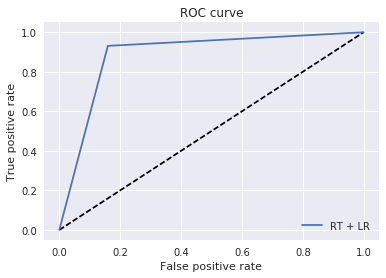

*********************************


0.88573870073941696

In [207]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_jobs=-1)
model.fit(X_train, y_train)
model.score(X_test, y_test)
complete_report(y_test, model.predict(X_test))

In [69]:
len(X_train.columns)

26

In [ ]:
import xgboost as xgb
from time import time
import numpy as np

start = time()
xg_train = xgb.DMatrix(X_train, label=y_train.values, missing=np.NaN)
xg_test = xgb.DMatrix(X_test, label=y_test.values, missing=np.NaN)
xg_val = xgb.DMatrix(X_val, label=y_val.values, missing=np.NaN)
param = {'max_depth':50, 
         'eta':0.2, 
         'silent':0, 
         'objective':'binary:logistic', 
         "booster": "gbtree", 
         "max_delta_step":1,
         "alpha": 0.2,
         "lambda": 0.2,
         #"scale_pos_weight": class_ratio,
         "eval_metric": "auc",
          "verbose": 1}

### Objectives
## 'binary:logistic'
## 'multi:softprob'
#param['num_class'] = 2
param["min_child_weight"] = 30
param["colsample_bytree"] = 0.5
num_round = 300

watchlist = [(xg_train,'train'), (xg_test,'test'), (xg_val,'validation')]
#watchlist = [(xg_val,'validation')]

bst = xgb.train(param, 
                xg_train, 
                num_round,
                watchlist,
                early_stopping_rounds=5)

yprob = bst.predict( xg_test ) #.reshape( y_test.shape[0], 2)
print(yprob[0])

print('Tempo de execução: {0}m{1}s'.format(int((time()-start)/60),
             int((time()-start)%60 )))

[0]	train-auc:0.761822	test-auc:0.752579	validation-auc:0.752491
Multiple eval metrics have been passed: 'validation-auc' will be used for early stopping.

Will train until validation-auc hasn't improved in 5 rounds.
[1]	train-auc:0.797848	test-auc:0.785805	validation-auc:0.785902
[2]	train-auc:0.813007	test-auc:0.799465	validation-auc:0.799531
[3]	train-auc:0.824392	test-auc:0.808551	validation-auc:0.808661
[4]	train-auc:0.831669	test-auc:0.813775	validation-auc:0.813871
[5]	train-auc:0.836734	test-auc:0.816578	validation-auc:0.816413
[6]	train-auc:0.840345	test-auc:0.818495	validation-auc:0.818364
[7]	train-auc:0.844826	test-auc:0.821303	validation-auc:0.821196
[8]	train-auc:0.848567	test-auc:0.823289	validation-auc:0.82316
[9]	train-auc:0.851977	test-auc:0.825349	validation-auc:0.825215
[10]	train-auc:0.854219	test-auc:0.827416	validation-auc:0.827304
[11]	train-auc:0.856938	test-auc:0.828647	validation-auc:0.828435
[12]	train-auc:0.859254	test-auc:0.829732	validation-auc:0.829509
[

In [145]:
y_pred = [1 if y > 0.5 else 0 for y in yprob]
#print(metrics.confusion_matrix(y_test, y_pred))
yprob = bst.predict( xg_test ) 
#complete_report(y_test, yprob)
len(yprob)

### Verificando a importância de cada feature para a previsão do modelo
import operator
importance = bst.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1), reverse=True)
for item in importance:
    print(item)

('context_type', 798)
('user_id', 615)
('nmidia_PROP_diff', 583)
('nmidia_regular_listened_PROP', 544)
('media_rank', 498)
('nmidia_with_flow', 462)
('nmidia_with_flow_listened_PROP', 444)
('nmidia_regular', 429)
('nmidia_with_flow_listened', 426)
('nmidia_regular_listened', 423)
('artist_fans', 394)
('artist_albuns', 321)
('diff_ts_listen_AND_release_date_Y', 265)
('album_id', 242)
('listen_type_1', 239)
('diff_user_song_age', 232)
('media_id', 219)
('user_age', 202)
('media_duration', 181)
('media_bpm', 177)
('genre_id', 174)
('platform_name', 172)
('platform_family', 150)
('diff_ts_listen_AND_release_date_M', 127)
('ts_listen_PERIOD_OF_DAY_2', 105)
('ts_listen_PERIOD_OF_DAY_3', 89)
('user_gender_1', 62)
('release_date_YEAR', 59)
('diff_ts_listen_AND_release_date_D', 58)
('ts_listen_DAY_OF_WEEK_5', 57)
('ts_listen_DAY_OF_WEEK_6', 48)
('ts_listen_PERIOD_OF_DAY_1', 40)
('ts_listen_DAY_OF_WEEK_1', 37)
('user_age_group', 31)
('ts_listen_DAY_OF_WEEK_4', 17)
('media_decade', 7)


In [146]:
df_test_group_1 = df_test[df_test["user_id_id"].isin(user_for_specific_model)].copy(deep=True)
xg_sub = xgb.DMatrix(df_test_group_1[features], missing=np.NaN)
p = bst.predict(xg_sub)

#p = model.predict_proba(df_test_group_1[features])
#p = p[:, 1]
df_test_group_1["prediction"] = p
df_test_group_1["prediction"].head()

0    0.998831
1    0.494440
2    0.789232
3    0.962189
4    0.862294
Name: prediction, dtype: float32

In [147]:
print(len(df_test))
print(len(df_test_group_1))
df_test_group_1[["prediction", "user_id_id"]]
df_test_group_1[["prediction", "user_id_id"]].to_csv("group1.csv")

19918
19256


In [148]:
import gc
gc.collect()
del df_test_group_1

In [149]:
import pandas as pd
from greenpyce.feature_engineering import TargetEncoder
from greenpyce.feature_engineering import onehot
from greenpyce.feature_engineering import RankCategorical
from greenpyce.feature_engineering import LabelCount
df_train = pd.read_csv("../data/train_data4.csv")
df_test = pd.read_csv("../data/test_data4.csv")

df_train["user_id_id"] = df_train["user_id"]
df_test["user_id_id"] = df_test["user_id"]

to_drop = ['Unnamed: 0', 'Unnamed: 0.1']
df_train.drop(to_drop, axis = 1,inplace=True)

# df_user = pd.read_csv("../data/nmidia_feats.csv", sep=";")
# # pd.isnull(df_user).sum()[pd.isnull(df_user).sum() > 0]
# df_user = df_user.drop(["nmidia_with_flow_listened_PROP", "nmidia_regular_listened_PROP", "nmidia_PROP_diff"], axis=1)
# df_user.columns.values
# df_train = pd.merge(df_train, df_user, on="user_id")
# df_test = pd.merge(df_test, df_user, on="user_id")
# del df_user


### select users for general

#df_train = df_train[df_train["user_id"].isin(user_for_general_model)]

threshold = 30

register_count = df_train["user_id"].value_counts()

user_for_general_model = register_count[(register_count <= threshold)].index
user_for_specific_model = register_count[(register_count > threshold)].index
print(len(user_for_general_model))
print(len(user_for_specific_model))

cols_for_target_encoder = ["genre_id", 
                           "media_id", 
                           "artist_radio"]

cols_for_onehot = ["platform_name", 
                   "user_age",
                   "listen_type",
                   "user_gender", 
                   "ts_listen_DAY_OF_WEEK",
                  "ts_listen_PERIOD_OF_DAY"]

cols_for_rank = ["artist_id",
                "artist_fans"]

target = "is_listened"

df_test = df_test[df_test["user_id"].isin(user_for_general_model)]
df_train.columns

te = TargetEncoder(cols_for_target_encoder, "is_listened")
te.fit(df_train)
te.transform(df_train)
te.transform(df_test)
del te

rc = RankCategorical(cols_for_rank)
rc.fit(df_train)
rc.transform(df_train)
rc.transform(df_test)
del rc

rc = RankCategorical(["media_decade"])
rc.fit(df_train)
rc.transform(df_train)
rc.transform(df_test)
del rc

df_train = onehot(df_train, cols_for_onehot)
df_test = onehot(df_test, cols_for_onehot)

%timeit
### Drop
to_drop = ['ts_listen', 'album_id', 'release_date', 'artist_id', "year", "text"]#, "nmidia_with_flow_listened_PROP", "nmidia_PROP_diff", "nmidia_regular_listened_PROP"]
df_train.drop(to_drop, axis = 1,inplace=True)
df_test.drop(to_drop, axis = 1,inplace=True)

features = [col for col in df_train.columns.values if col != target]
features

2630
17288


['genre_id',
 'media_id',
 'context_type',
 'platform_family',
 'media_duration',
 'user_id',
 'diff_ts_listen_AND_release_date_D',
 'diff_ts_listen_AND_release_date_M',
 'diff_ts_listen_AND_release_date_Y',
 'release_date_DAY',
 'release_date_MONTH',
 'release_date_YEAR',
 'user_age_group',
 'diff_user_song_age',
 'media_decade',
 'artist_albuns',
 'artist_fans',
 'artist_radio',
 'media_bpm',
 'media_rank',
 'user_id_id',
 'platform_name_1',
 'platform_name_2',
 'user_age_19',
 'user_age_20',
 'user_age_21',
 'user_age_22',
 'user_age_23',
 'user_age_24',
 'user_age_25',
 'user_age_26',
 'user_age_27',
 'user_age_28',
 'user_age_29',
 'user_age_30',
 'listen_type_1',
 'user_gender_1',
 'ts_listen_DAY_OF_WEEK_1',
 'ts_listen_DAY_OF_WEEK_2',
 'ts_listen_DAY_OF_WEEK_3',
 'ts_listen_DAY_OF_WEEK_4',
 'ts_listen_DAY_OF_WEEK_5',
 'ts_listen_DAY_OF_WEEK_6',
 'ts_listen_PERIOD_OF_DAY_1',
 'ts_listen_PERIOD_OF_DAY_2',
 'ts_listen_PERIOD_OF_DAY_3']

In [150]:
features

['genre_id',
 'media_id',
 'context_type',
 'platform_family',
 'media_duration',
 'user_id',
 'diff_ts_listen_AND_release_date_D',
 'diff_ts_listen_AND_release_date_M',
 'diff_ts_listen_AND_release_date_Y',
 'release_date_DAY',
 'release_date_MONTH',
 'release_date_YEAR',
 'user_age_group',
 'diff_user_song_age',
 'media_decade',
 'artist_albuns',
 'artist_fans',
 'artist_radio',
 'media_bpm',
 'media_rank',
 'user_id_id',
 'platform_name_1',
 'platform_name_2',
 'user_age_19',
 'user_age_20',
 'user_age_21',
 'user_age_22',
 'user_age_23',
 'user_age_24',
 'user_age_25',
 'user_age_26',
 'user_age_27',
 'user_age_28',
 'user_age_29',
 'user_age_30',
 'listen_type_1',
 'user_gender_1',
 'ts_listen_DAY_OF_WEEK_1',
 'ts_listen_DAY_OF_WEEK_2',
 'ts_listen_DAY_OF_WEEK_3',
 'ts_listen_DAY_OF_WEEK_4',
 'ts_listen_DAY_OF_WEEK_5',
 'ts_listen_DAY_OF_WEEK_6',
 'ts_listen_PERIOD_OF_DAY_1',
 'ts_listen_PERIOD_OF_DAY_2',
 'ts_listen_PERIOD_OF_DAY_3']

In [151]:
len(df_test)

2630

In [152]:
# features =['genre_id', 
#            'media_id', 
#            'context_type', 
#     #       'media_duration', 
#            'listen_type', 
#     #       'user_id', 
#    #        'diff_ts_listen_AND_release_date_D', 
#            'diff_ts_listen_AND_release_date_M', 
#    #        'diff_ts_listen_AND_release_date_Y', 
#     #       'release_date_YEAR', 
#            'diff_user_song_age', 
#            'artist_albuns', 
#            'artist_fans', 
#            'artist_radio', 
#            'media_bpm', 
#            'media_rank', 
#            #'user_id_id', 
# #            'nmidia_regular_listened', 
# #            'nmidia_with_flow_listened', 
# #            'nmidia_regular', 
# #            'nmidia_with_flow', 
#            'platform_name_1', 
#            'platform_name_2', 
#            'platform_family_1', 
#            'platform_family_2', 
#            'user_age_19', 
#            'user_age_20', 
#            'user_age_21', 
#            'user_age_22', 
#            'user_age_23', 
#            'user_age_25', 
#            'user_age_26', 
#            'user_age_27', 
#            'user_age_28', 
#            'user_age_29', 
#            'user_age_30', 
#            'user_age_group_1',
#            'user_age_group_2', 
# #            'media_decade_1', 
#            'media_decade_2',
#            'media_decade_5', 
#            'media_decade_7', 
#            'media_decade_8', 
#            'user_gender_1', 
#            'user_age_group_1', 
#            'user_age_group_2', 
#            'ts_listen_DAY_OF_WEEK_1',
#            'ts_listen_DAY_OF_WEEK_2', 
#            'ts_listen_DAY_OF_WEEK_3', 
#            'ts_listen_DAY_OF_WEEK_4', 
#            'ts_listen_DAY_OF_WEEK_5',
#            'ts_listen_PERIOD_OF_DAY_2', 
#            'ts_listen_PERIOD_OF_DAY_3']

['genre_id', 'media_id', 'context_type', 'media_duration', 'listen_type', 'user_id', 'diff_ts_listen_AND_release_date_D', 'diff_ts_listen_AND_release_date_M', 'diff_ts_listen_AND_release_date_Y', 'release_date_YEAR', 'diff_user_song_age', 'artist_albuns', 'artist_fans', 'artist_radio', 'media_bpm', 'media_rank', 'user_id_id', 'nmidia_regular_listened', 'nmidia_with_flow_listened', 'nmidia_regular', 'nmidia_with_flow', 'platform_name_1', 'platform_name_2', 'platform_family_1', 'platform_family_2', 'user_age_19', 'user_age_20', 'user_age_21', 'user_age_22', 'user_age_23', 'user_age_25', 'user_age_26', 'user_age_27', 'user_age_28', 'user_age_29', 'user_age_30', 'user_age_group_1', 'user_age_group_2', 'media_decade_1', 'media_decade_2', 'media_decade_5', 'media_decade_7', 'media_decade_8', 'user_gender_1', 'user_age_group_1', 'user_age_group_2', 'ts_listen_DAY_OF_WEEK_1', 'ts_listen_DAY_OF_WEEK_2', 'ts_listen_DAY_OF_WEEK_3', 'ts_listen_DAY_OF_WEEK_4', 'ts_listen_DAY_OF_WEEK_5', 'ts_listen_PERIOD_OF_DAY_2', 'ts_listen_PERIOD_OF_DAY_3']

In [153]:
### 0.7678

for column in features:
    try:
        df_test[column] = df_test[column].fillna(df_train[column].mean(skipna=True))
    except:
        df_test[column] = 0

#df_test = df_test.fillna(df_train.mean(skipna=True), axis=1)
df_test = df_test.applymap(lambda x : float(x))
pd.isnull(df_test).sum().sum()

0

In [154]:
# df_test = df_test.fillna(df_train.mean(skipna=True).to_dict, axis=1)#.dropna(axis=1, how='all')
# pd.isnull(df_test).sum()
# df_train.mean(skipna=True).to_dict
features = ['media_duration',
 'artist_id',
 'diff_ts_listen_AND_release_date_M',
 'diff_user_song_age',
 'artist_albuns',
 'artist_fans',
 'media_bpm',
 'media_rank',
 'listen_type_1',
 'user_gender_1',
 'ts_listen_DAY_OF_WEEK_1',
 'ts_listen_DAY_OF_WEEK_2',
 'ts_listen_DAY_OF_WEEK_3',
 'ts_listen_DAY_OF_WEEK_4',
 'ts_listen_DAY_OF_WEEK_5',
 'ts_listen_DAY_OF_WEEK_6',
 'ts_listen_PERIOD_OF_DAY_1',
 'ts_listen_PERIOD_OF_DAY_2',
 'ts_listen_PERIOD_OF_DAY_3']

In [155]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_train[features], df_train[target], test_size = 0.2)

from sklearn import feature_selection
all_features = features
function_rule_selection = feature_selection.f_classif
alpha_cutoff = 0.001

selection_rule = feature_selection.SelectFdr(function_rule_selection, alpha_cutoff)
selection_rule.fit(X_train, y_train);

all_pvalues = list(filter(lambda x: pd.notnull(x[0]), zip(selection_rule.pvalues_, all_features)))
#print(all_pvalues)
filtered_pvalues = list(filter(lambda x: x[0]<=alpha_cutoff, all_pvalues))
#print(filtered_pvalues)
all_select_features = list(map(lambda x: x[1], filtered_pvalues))

print("{0} selected variables from {1}, {2:.2f}%".format(len(all_select_features), 
                                                        len(all_features), 
                                                        len(filtered_pvalues)*100/float(len(all_features))))
print(all_select_features)
#print(filtered_pvalues)

features = all_select_features
X_train, X_test, y_train, y_test = train_test_split(df_train[features], df_train[target], test_size = 0.3)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5)

MemoryError: 

In [ ]:
import xgboost as xgb
from time import time
import numpy as np

start = time()
xg_train = xgb.DMatrix(X_train, label=y_train.values, missing=np.NaN)
xg_test = xgb.DMatrix(X_test, label=y_test.values, missing=np.NaN)
xg_val = xgb.DMatrix(X_val, label=y_val.values, missing=np.NaN)
param = {'max_depth':5, 
         'eta':0.2, 
         'silent':0, 
         'objective':'binary:logistic', 
         "booster": "gbtree", 
         "max_delta_step":1,
         "alpha": 0,
         "lambda": 0,
         #"scale_pos_weight": class_ratio,
         "eval_metric": "auc",
          "verbose": 1}

### Objectives
## 'binary:logistic'
## 'multi:softprob'
#param['num_class'] = 2
param["min_child_weight"] = 30
param["colsample_bytree"] = 0.5
num_round = 300

watchlist = [(xg_train,'train'), (xg_test,'test'), (xg_val,'validation')]
#watchlist = [(xg_val,'validation')]

bst = xgb.train(param, 
                xg_train, 
                num_round,
                watchlist,
                early_stopping_rounds=5)

yprob = bst.predict( xg_test ) #.reshape( y_test.shape[0], 2)
print(yprob[0])

print('Tempo de execução: {0}m{1}s'.format(int((time()-start)/60),
             int((time()-start)%60 )))

In [ ]:
df_test_group_2 = df_test[df_test["user_id_id"].isin(user_for_general_model)].copy(deep=True)
xg_sub = xgb.DMatrix(df_test_group_2[features], missing=np.NaN)
p = bst.predict(xg_sub)
df_test_group_2["prediction"] = p
df_test_group_2["prediction"].head()

In [ ]:
df_test_group_2[["user_id_id", "prediction"]].to_csv("group2.csv")

In [ ]:
df_test_group_1 = pd.read_csv("group1.csv", index_col="user_id_id")
df_test_group_2 = pd.read_csv("group2.csv", index_col="user_id_id")

In [ ]:
df_test = pd.read_csv("../data/test_data4.csv")
#df_test = df_test["user_id"]
#df_test["user_id_id"] = df_test["user_id"]
# df_test = pd.merge(df_test, df_test_group_1[["user_id", "prediction"]], on="user_id")
# df_test = pd.merge(df_test, df_test_group_2[["user_id", "prediction"]], on="user_id")
df_test = pd.merge(df_test, df_test_group_1[["prediction"]], left_on="user_id", right_index=True, how="outer")
#df_test.join(df_test_group_2[["prediction"]])
df_test = pd.merge(df_test, df_test_group_2[["prediction"]], left_on="user_id", right_index=True, how="outer")

In [ ]:
print(len(df_test_group_1))
print(len(df_test_group_2))
print(len(df_test))

In [ ]:
#pd.set_option("precision", 10)
#df_test_group_2[["user_id", "prediction"]].head()
a = pd.read_csv("../data/test_data4.csv")

In [ ]:
a["user_id"].head()

In [ ]:
df_test.head()

In [ ]:
df_test["prediction_x"].fillna(0, inplace=True)
df_test["prediction_y"].fillna(0, inplace=True)
df_test["prediction"] = df_test["prediction_x"] + df_test["prediction_y"]

In [ ]:
df_test["prediction"].head()

In [ ]:
df_test.ix[8716]["prediction"]

In [ ]:
df_test["prediction"].values[:5]

In [ ]:
len(df_test)

In [ ]:
(df_test["prediction"] > 1.0).sum()

In [ ]:
(df_test["prediction"] == 1.0).sum()

In [ ]:
(df_test["prediction"] == 0).sum()

In [ ]:
pd.isnull(df_test["prediction_y"]).sum()

In [ ]:
#df_test["prediction"] = df_test["prediction"].apply(lambda x : 1 if x > 1 else x)

In [ ]:
import gzip
import csv
import numpy as np

def build_kaggle_submission(preds, filename="my_submission"):
    """
    Build a compressed Kaggle Submission
    
    preds: array with predictions
    """
    with gzip.open(filename + '.csv.gz', 'wt') as outf:
        fo = csv.writer(outf, lineterminator='\n')
        fo.writerow(["sample_id", "is_listened"])       
        for i, pred in enumerate(preds):
            fo.writerow([i, pred])

In [ ]:
#p = model.predict_proba(df_test[features])
#p = p[:, 1]
p = df_test["prediction"].values

In [ ]:
build_kaggle_submission(p, "note20_1")

In [ ]:
import sys
print(sys.getsizeof(df_train) / 1e6)
print(sys.getsizeof(df_test) / 1e6)
print(sys.getsizeof(model) / 1e6)

In [ ]:
!ls